# Black Friday Sales Preciction

### 问题描述：

黑色星期五是美国感恩节后的星期五，通常被称为黑色星期五。感恩节在每年11月的第四个星期四庆祝。自1952年起，感恩节后的第二天被视为美国圣诞购物季的开始，尽管直到最近几十年，"黑色星期五"这个术语才变得广泛使用。许多商店在黑色星期五提供大力推广的促销活动，非常早就开门，比如午夜，甚至可能在感恩节当天就开始销售。对于零售店或电子商务企业来说，最大的挑战是选择产品价格，以便在销售结束时获得最大利润。我们的项目涉及根据历史零售店销售数据确定产品价格。在生成预测之后，我们的模型将帮助零售店确定产品的价格以获取更多利润。

一家零售公司“ABC Private Limited”想了解顾客对不同品类的各种产品的购买行为(具体而言，购买金额)。他们分享了上个月以来各种客户对选定的大批量产品的采购摘要。
该数据集还包含客户人口统计数据(年龄、性别、婚姻状况、城市类型、当前城市)、产品详细信息(productid和产品类别)以及上个月的总购买金额。

现在，他们想建立一个模型来预测客户对各种产品的购买量，这将有助于他们为不同产品的客户创建个性化的报价。

##### 任务：

购买栏是目标变量，对购买执行单变量分析和双变量分析。

在列描述中masked表示已从分类值转换为数值列。

#### 数据字典：

|变量名  |含义 |
-----|-----| 
|User_ID | User ID |
|Product_ID | Product ID |
|Gender | Sex of User |
|Age | Age in bins |
|Occupation | Occupation (Masked) |
|City_Category | Category of the City (A, B, C) |
|Stay_In_Current_City_Years | Number of years stay in current city |
|Marital_Status | Marital Status |
|Product_Category_1 | Product Category (Masked) |
|Product_Category_2 | Product may belong to other categories also (Masked) |
|Product_Category_3 | Product may belong to other categories also (Masked) |
|Purchase | Purchase Amount (Target Variable) |

In [1]:
# 导入
import pandas as pd
import numpy as np
import matplotlib as mpl
# mpl.use('nbAgg')  #绘制交互式图片
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree

import pickle

#内置魔法函数，不再用plt.show()
%matplotlib inline 

In [2]:
# 读入数据
df0 = pd.read_csv('BlackFriday.csv')
df0.head()

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN      1422  
3                14.0                 NaN      1057  
4                 NaN                 NaN      7969

In [3]:
# 懒人版EDA，一键实现

# pip install ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(df0, title="Profiling Report")
profile 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# 将EDA输出保存
profile.to_file('BlackFriday_EDA.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 探索性数据分析 EDA

In [5]:
df0.shape

(537577, 12)

In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     537577 non-null  int64  
 1   Product_ID                  537577 non-null  object 
 2   Gender                      537577 non-null  object 
 3   Age                         537577 non-null  object 
 4   Occupation                  537577 non-null  int64  
 5   City_Category               537577 non-null  object 
 6   Stay_In_Current_City_Years  537577 non-null  object 
 7   Marital_Status              537577 non-null  int64  
 8   Product_Category_1          537577 non-null  int64  
 9   Product_Category_2          370591 non-null  float64
 10  Product_Category_3          164278 non-null  float64
 11  Purchase                    537577 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [7]:
# 标签类数据
for col in df0.iloc[:,2:11].columns:
    print(str(col)+':', df0[col].unique())

Gender: ['F' 'M']
Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category: ['A' 'C' 'B']
Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
Marital_Status: [0 1]
Product_Category_1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9]
Product_Category_2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


In [8]:
df0.describe(include='all')

User_ID Product_ID  Gender     Age    Occupation City_Category  \
count   5.375770e+05     537577  537577  537577  537577.00000        537577   
unique           NaN       3623       2       7           NaN             3   
top              NaN  P00265242       M   26-35           NaN             B   
freq             NaN       1858  405380  214690           NaN        226493   
mean    1.002992e+06        NaN     NaN     NaN       8.08271           NaN   
std     1.714393e+03        NaN     NaN     NaN       6.52412           NaN   
min     1.000001e+06        NaN     NaN     NaN       0.00000           NaN   
25%     1.001495e+06        NaN     NaN     NaN       2.00000           NaN   
50%     1.003031e+06        NaN     NaN     NaN       7.00000           NaN   
75%     1.004417e+06        NaN     NaN     NaN      14.00000           NaN   
max     1.006040e+06        NaN     NaN     NaN      20.00000           NaN   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
count                      537577   537577.000000       537577.000000   
unique                          5             NaN                 NaN   
top                             1             NaN                 NaN   
freq                       189192             NaN                 NaN   
mean                          NaN        0.408797            5.295546   
std                           NaN        0.491612            3.750701   
min                           NaN        0.000000            1.000000   
25%                           NaN        0.000000            1.000000   
50%                           NaN        0.000000            5.000000   
75%                           NaN        1.000000            8.000000   
max                           NaN        1.000000           18.000000   

        Product_Category_2  Product_Category_3       Purchase  
count        370591.000000       164278.000000  537577.000000  
unique                 NaN                 NaN            NaN  
top                    NaN                 NaN            NaN  
freq                   NaN                 NaN            NaN  
mean              9.842144           12.669840    9333.859853  
std               5.087259            4.124341    4981.022133  
min               2.000000            3.000000     185.000000  
25%               5.000000            9.000000    5866.000000  
50%               9.000000           14.000000    8062.000000  
75%              15.000000           16.000000   12073.000000  
max              18.000000           18.000000   23961.000000

In [9]:
df0.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [10]:
# 输出各列中的标签占比
for col in df0.iloc[:,2:11].columns:
    print(df0[col].value_counts(dropna=False, normalize=True), '\n') # dropna=False, 包含空值

Gender
M    0.754087
F    0.245913
Name: proportion, dtype: float64 

Age
26-35    0.399366
36-45    0.199969
18-25    0.181619
46-50    0.082827
51-55    0.069977
55+      0.038884
0-17     0.027358
Name: proportion, dtype: float64 

Occupation
4     0.131817
0     0.126717
7     0.107531
1     0.085515
17    0.072715
20    0.061219
12    0.056593
14    0.049690
2     0.048077
16    0.046114
6     0.036873
3     0.032304
10    0.023481
5     0.022294
15    0.021973
11    0.021091
19    0.015536
13    0.014041
18    0.012138
9     0.011446
8     0.002835
Name: proportion, dtype: float64 

City_Category
B    0.421322
C    0.309623
A    0.269055
Name: proportion, dtype: float64 

Stay_In_Current_City_Years
1     0.351935
2     0.185013
3     0.173579
4+    0.154190
0     0.135283
Name: proportion, dtype: float64 

Marital_Status
0    0.591203
1    0.408797
Name: proportion, dtype: float64 

Product_Category_1
5     0.276411
1     0.257364
8     0.208588
11    0.044570
2     0.043713
6   

以上结果中，`Product_Category_2`中空值占比0.310627，`Product_Category_3`中空值占比0.694410，其余列无空值

In [11]:
# 查看含空值的行数
df0.isna().any(axis=1).sum()

373299

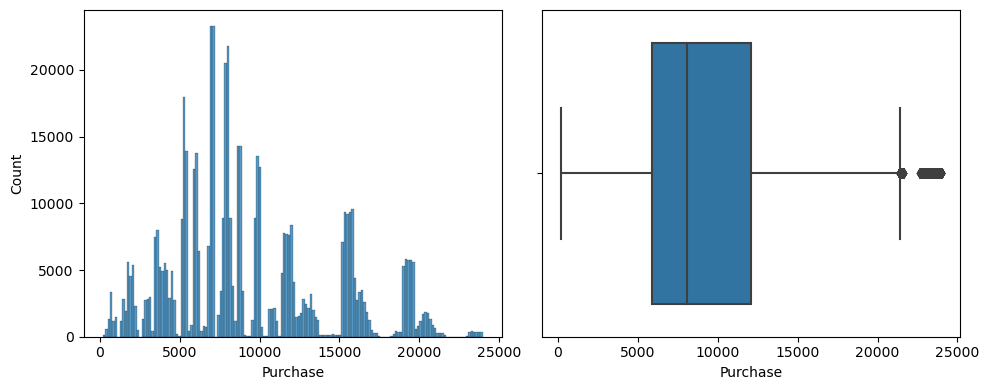

In [12]:
# 查看Purchase的分布
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df0.Purchase, ax=axes[0])
sns.boxplot(x=df0.Purchase, ax=axes[1])

plt.tight_layout()

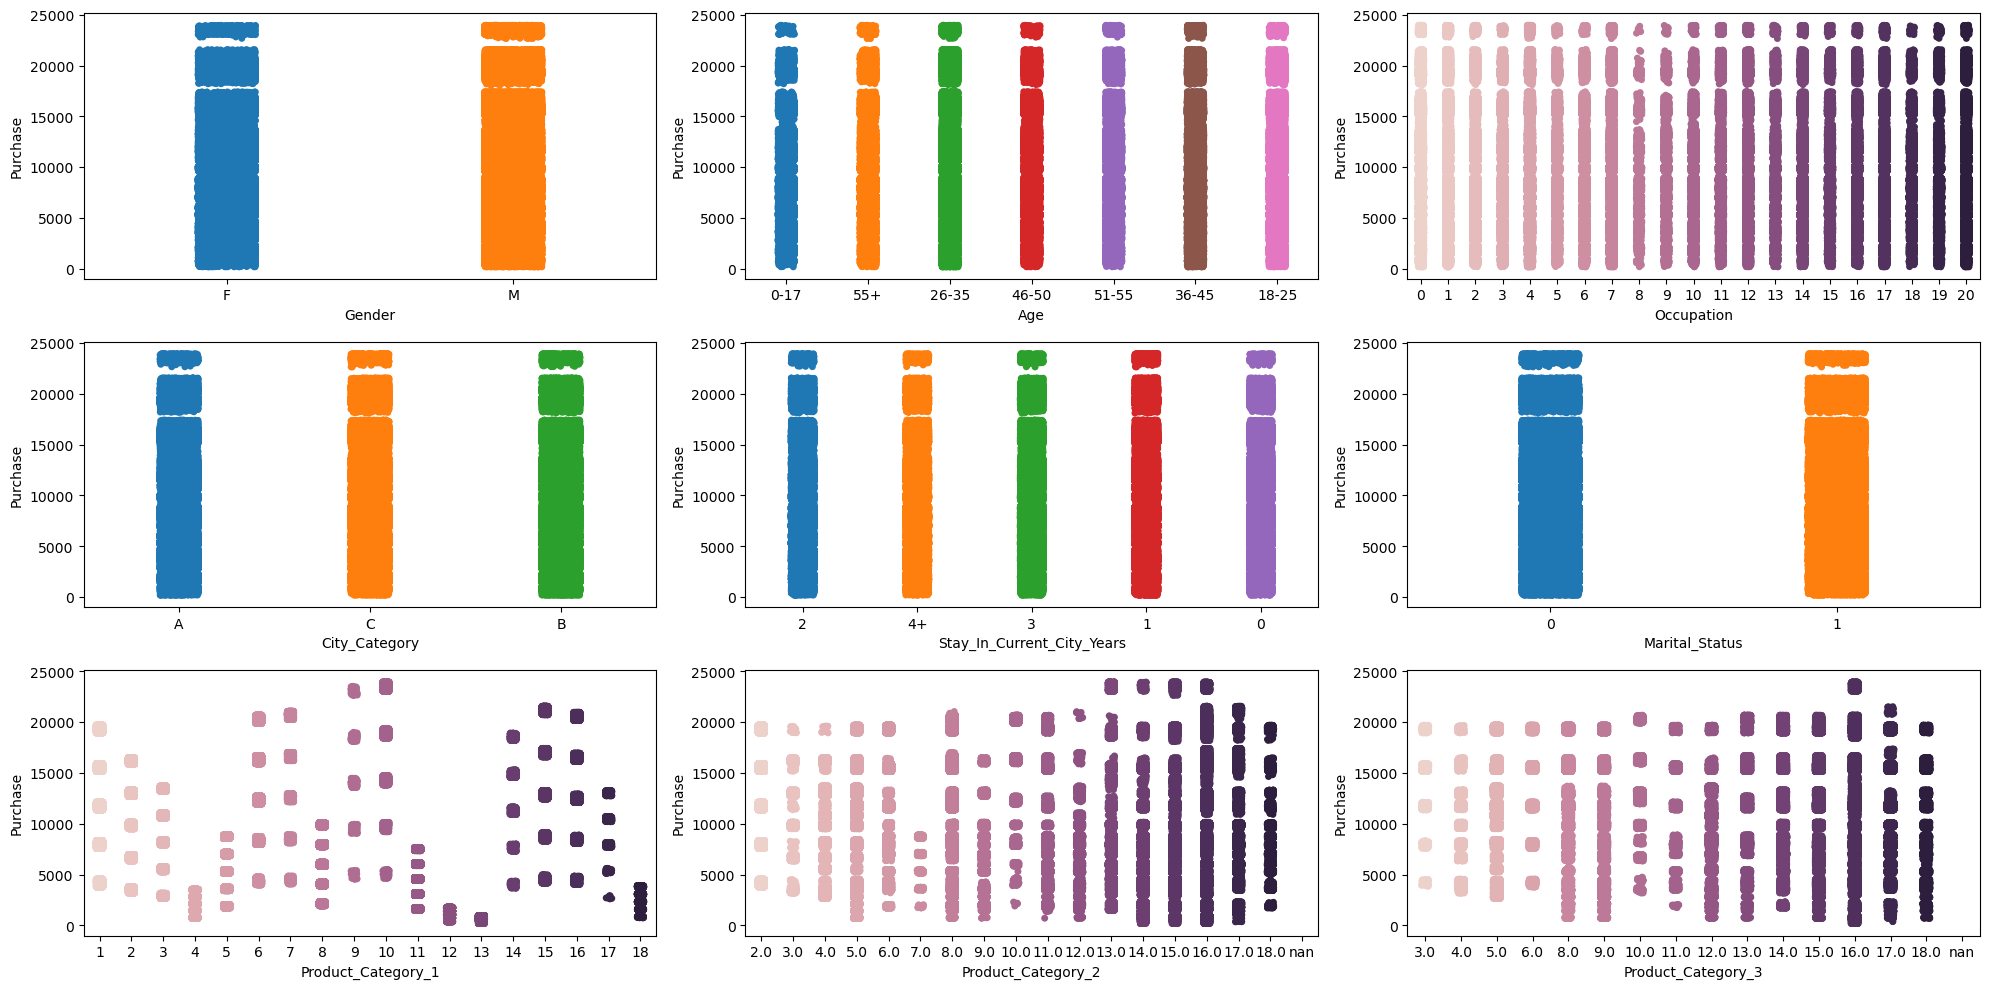

In [13]:
# 查看类别特征与Purchase
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(df0.iloc[:,2:11].columns):
    sns.stripplot(x=col, y='Purchase', hue=col, data=df0, ax=axes[i], legend=False)
    
plt.tight_layout()

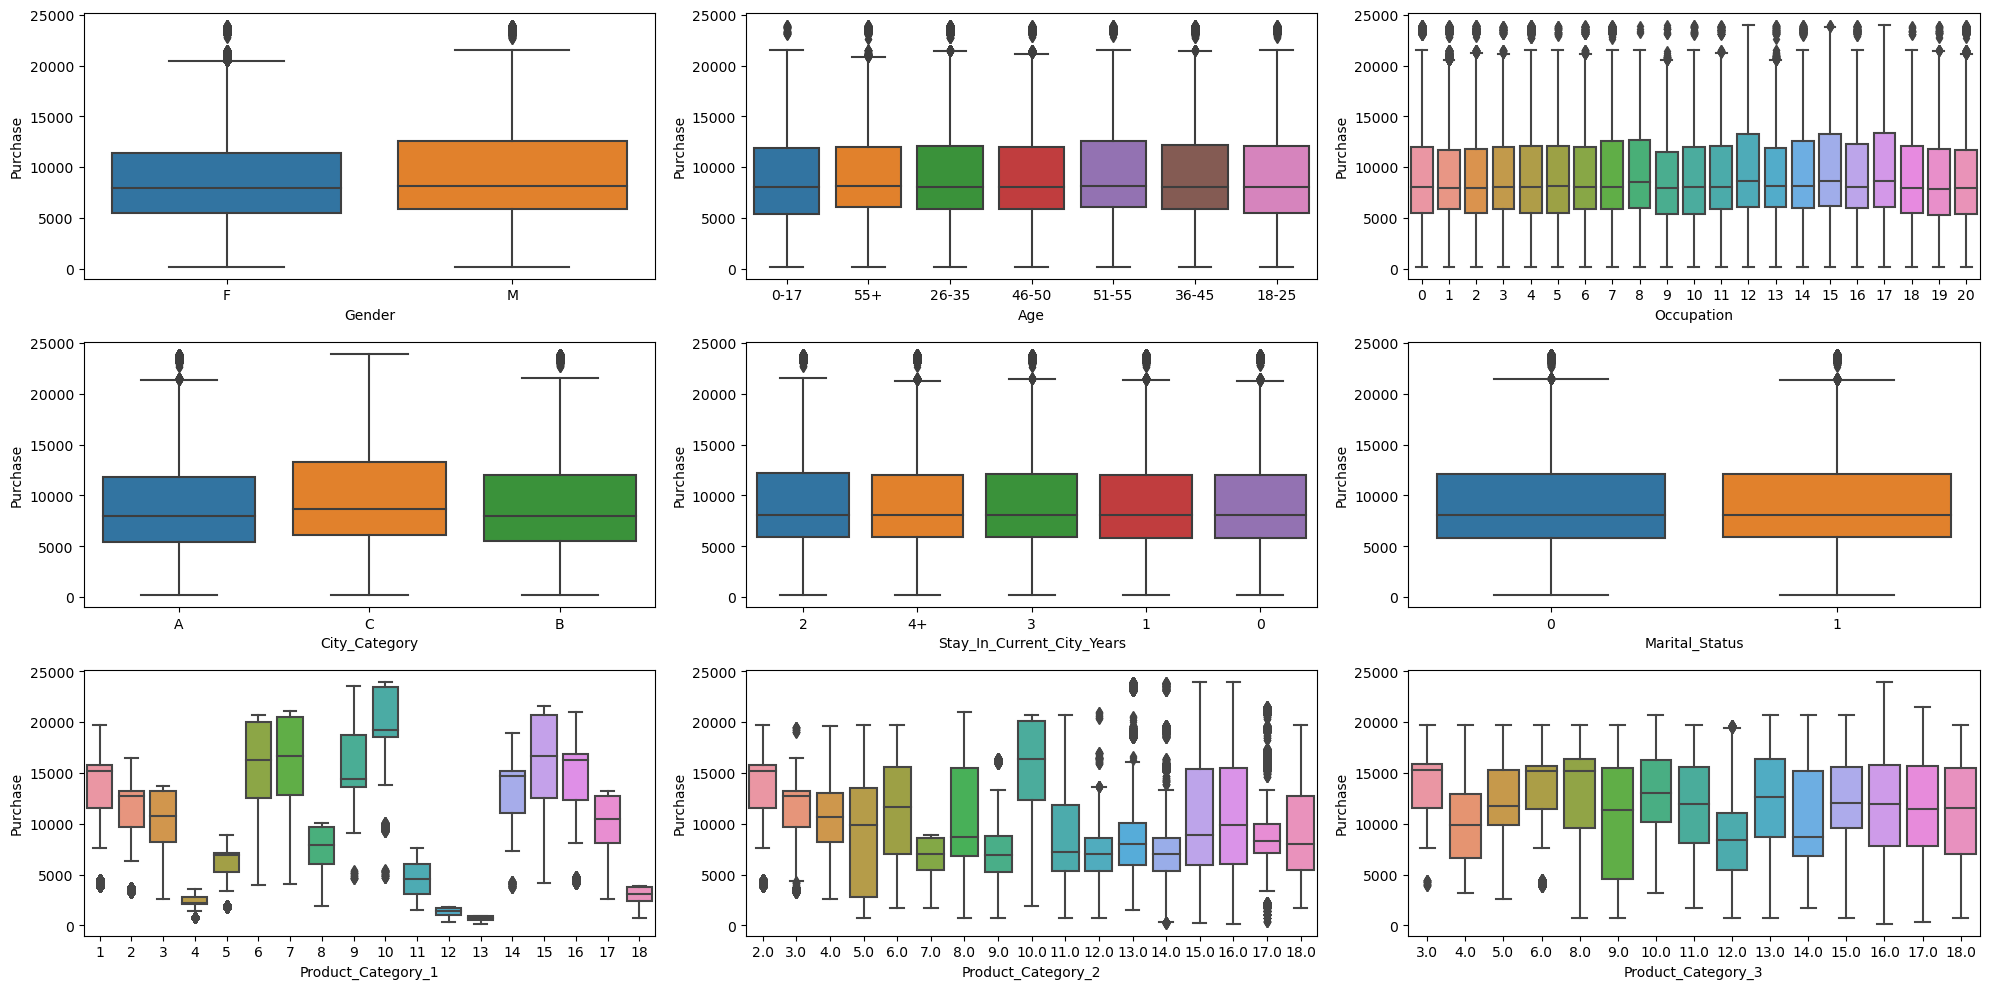

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(df0.iloc[:,2:11].columns):
    sns.boxplot(x=col, y='Purchase', data=df0, ax=axes[i])
    
plt.tight_layout()
plt.show()

### 将数据拆分成用户信息、产品信息分别描述

In [15]:
# 提取所有用户信息
user_data = df0[['User_ID', 'Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']]
user_data.head()

User_ID Gender   Age  Occupation City_Category Stay_In_Current_City_Years  \
0  1000001      F  0-17          10             A                          2   
1  1000001      F  0-17          10             A                          2   
2  1000001      F  0-17          10             A                          2   
3  1000001      F  0-17          10             A                          2   
4  1000002      M   55+          16             C                         4+   

   Marital_Status  
0               0  
1               0  
2               0  
3               0  
4               0

In [16]:
# 用户的数量
user_data.User_ID.nunique()

5891

In [17]:
# 查看去掉重复行后，行数是否与用户总数一致
user_data.shape[0] - user_data.duplicated().sum()

5891

去掉重复行后，行数与用户总数一致，因此每个用户只保留一行

In [18]:
# 删除重复行
user_data = user_data.drop_duplicates(keep='first')
user_data.head()

User_ID Gender    Age  Occupation City_Category Stay_In_Current_City_Years  \
0  1000001      F   0-17          10             A                          2   
4  1000002      M    55+          16             C                         4+   
5  1000003      M  26-35          15             A                          3   
6  1000004      M  46-50           7             B                          2   
9  1000005      M  26-35          20             A                          1   

   Marital_Status  
0               0  
4               0  
5               0  
6               1  
9               1

In [19]:
# 产品信息数据
product_data = df0[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
product_data.Product_ID.nunique() == product_data.shape[0] - product_data.duplicated().sum() #判断

True

In [20]:
product_data = product_data.drop_duplicates(keep='first')
product_data.head()

Product_ID  Product_Category_1  Product_Category_2  Product_Category_3
0  P00069042                   3                 NaN                 NaN
1  P00248942                   1                 6.0                14.0
2  P00087842                  12                 NaN                 NaN
3  P00085442                  12                14.0                 NaN
4  P00285442                   8                 NaN                 NaN

#### 用户/产品画像

Gender
M    0.717196
F    0.282804
Name: proportion, dtype: float64 



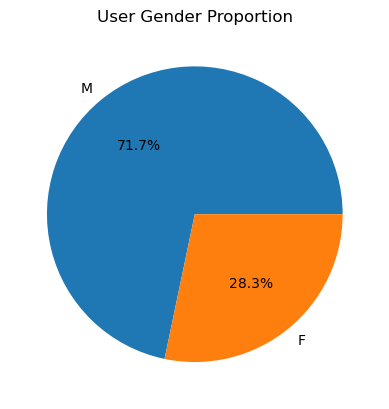

Age
26-35    0.348498
36-45    0.198099
18-25    0.181463
46-50    0.090137
51-55    0.081650
55+      0.063147
0-17     0.037006
Name: proportion, dtype: float64 



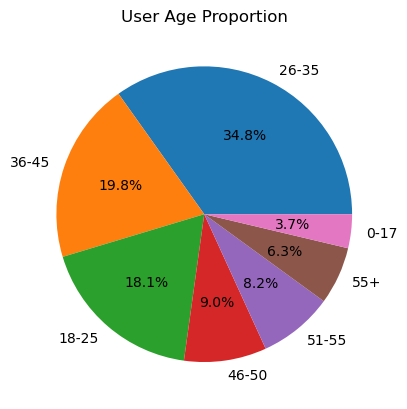

Occupation
4     0.125615
0     0.116788
7     0.113563
1     0.087761
17    0.083347
12    0.063826
14    0.049907
20    0.046342
2     0.043456
16    0.039891
6     0.038703
10    0.032592
3     0.028858
15    0.023765
13    0.023765
11    0.021728
5     0.018842
9     0.014938
19    0.012052
18    0.011373
8     0.002886
Name: proportion, dtype: float64 



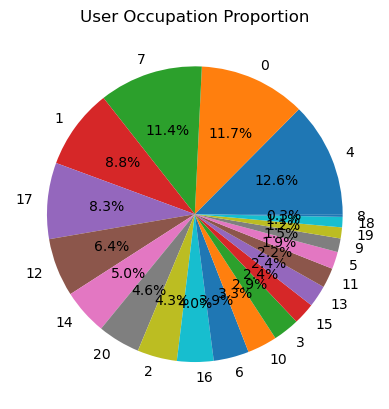

City_Category
C    0.532847
B    0.289764
A    0.177389
Name: proportion, dtype: float64 



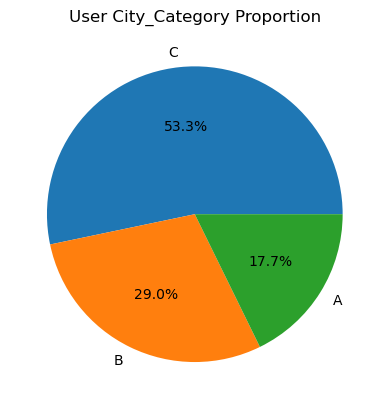

Stay_In_Current_City_Years
1     0.354099
2     0.194364
3     0.166186
4+    0.154303
0     0.131047
Name: proportion, dtype: float64 



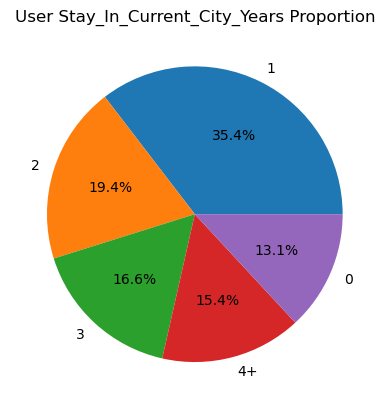

Marital_Status
0    0.580037
1    0.419963
Name: proportion, dtype: float64 



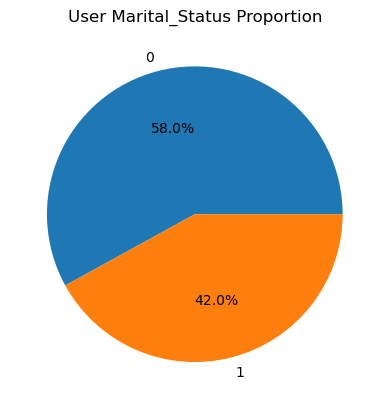

In [21]:
# 用户画像
for col in user_data.drop('User_ID', axis=1).columns:
    print(user_data[col].value_counts(normalize=True, dropna=False), '\n')
    plt.pie(x=user_data[col].value_counts(normalize=True, dropna=False), labels=user_data[col].value_counts(normalize=True, dropna=False).index, autopct="%0.1f%%")
    plt.title('User ' + col + ' Proportion')
    plt.show()

Product_Category_1
8     0.288987
5     0.266630
1     0.135523
11    0.070108
2     0.041954
6     0.032846
7     0.028153
16    0.027049
3     0.024841
4     0.024289
14    0.012145
15    0.012145
13    0.009661
18    0.008280
12    0.006900
10    0.006900
17    0.003036
9     0.000552
Name: proportion, dtype: float64 



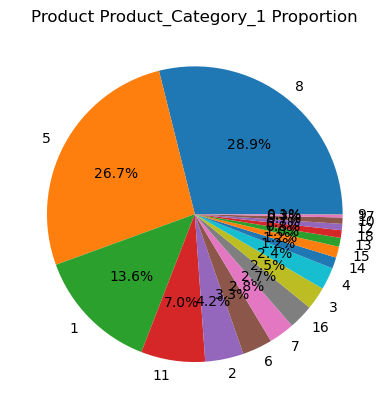

Product_Category_2
NaN     0.503174
8.0     0.097433
14.0    0.087497
16.0    0.060999
4.0     0.040298
15.0    0.038090
5.0     0.035330
2.0     0.035054
17.0    0.020977
11.0    0.019321
6.0     0.016561
13.0    0.014077
12.0    0.012421
9.0     0.005520
18.0    0.004968
10.0    0.003864
3.0     0.003312
7.0     0.001104
Name: proportion, dtype: float64 



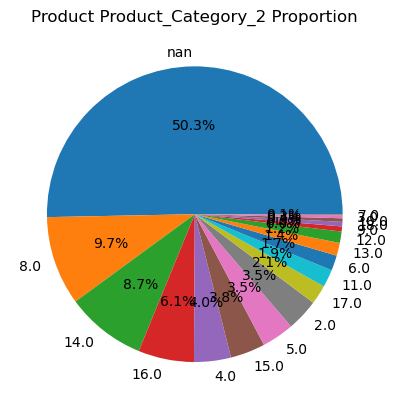

Product_Category_3
NaN     0.854816
16.0    0.031742
14.0    0.022081
15.0    0.019045
5.0     0.011869
17.0    0.011593
8.0     0.010213
9.0     0.010213
12.0    0.008556
13.0    0.004416
4.0     0.003864
6.0     0.003864
18.0    0.003864
11.0    0.001656
10.0    0.001380
3.0     0.000828
Name: proportion, dtype: float64 



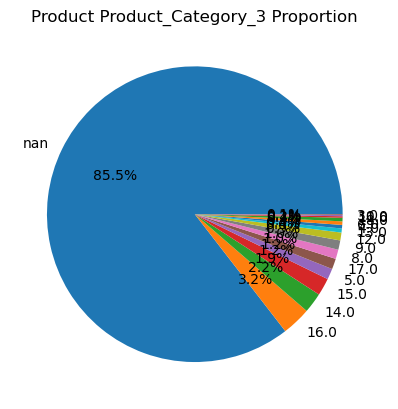

In [22]:
# 产品画像（包含空值）
for col in product_data.drop('Product_ID', axis=1).columns:
    print(product_data[col].value_counts(normalize=True, dropna=False), '\n')
    plt.pie(x=product_data[col].value_counts(normalize=True, dropna=False), labels=product_data[col].value_counts(normalize=True, dropna=False).index, autopct="%0.1f%%")
    plt.title('Product ' + col + ' Proportion')
    plt.show()

对于去重后的产品信息表，`Product_Category_2`的缺失值比例达到了50%，`Product_Category_3`的缺失值比例达到了85%。

Product_Category_1
8     0.288987
5     0.266630
1     0.135523
11    0.070108
2     0.041954
6     0.032846
7     0.028153
16    0.027049
3     0.024841
4     0.024289
14    0.012145
15    0.012145
13    0.009661
18    0.008280
12    0.006900
10    0.006900
17    0.003036
9     0.000552
Name: proportion, dtype: float64 



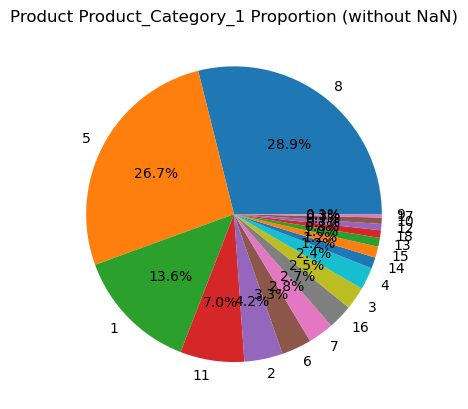

Product_Category_2
8.0     0.196111
14.0    0.176111
16.0    0.122778
4.0     0.081111
15.0    0.076667
5.0     0.071111
2.0     0.070556
17.0    0.042222
11.0    0.038889
6.0     0.033333
13.0    0.028333
12.0    0.025000
9.0     0.011111
18.0    0.010000
10.0    0.007778
3.0     0.006667
7.0     0.002222
Name: proportion, dtype: float64 



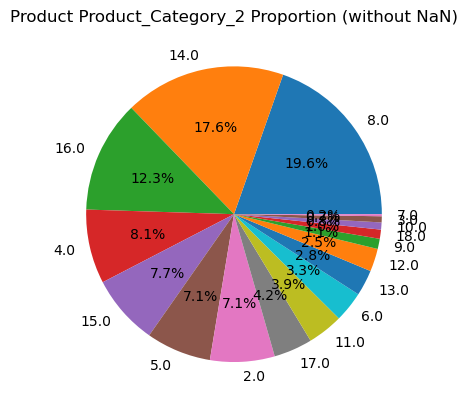

Product_Category_3
16.0    0.218631
14.0    0.152091
15.0    0.131179
5.0     0.081749
17.0    0.079848
8.0     0.070342
9.0     0.070342
12.0    0.058935
13.0    0.030418
4.0     0.026616
6.0     0.026616
18.0    0.026616
11.0    0.011407
10.0    0.009506
3.0     0.005703
Name: proportion, dtype: float64 



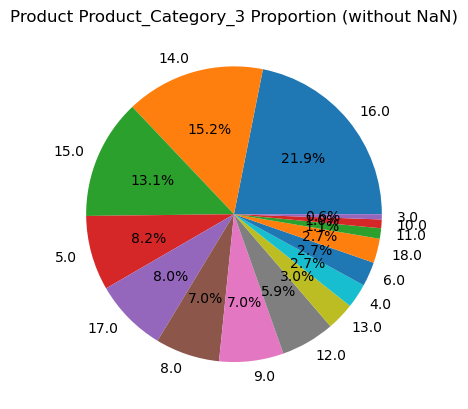

In [23]:
# 输出不包含空值的产品画像
for col in product_data.drop('Product_ID', axis=1).columns:
    print(product_data[col].value_counts(normalize=True), '\n')
    plt.pie(x=product_data[col].value_counts(normalize=True), labels=product_data[col].value_counts(normalize=True).index, autopct="%0.1f%%")
    plt.title('Product ' + col + ' Proportion (without NaN)')
    plt.show()

#### 将Purchase数据与用户数据、产品数据合并，在两个数据表上显示每个用户或每个产品的Purchase总数，并对Purchase进行EDA

In [24]:
user_data = pd.merge(user_data, df0.groupby('User_ID')['Purchase'].sum(), how='left', on='User_ID')
user_data.head()

User_ID Gender    Age  Occupation City_Category Stay_In_Current_City_Years  \
0  1000001      F   0-17          10             A                          2   
1  1000002      M    55+          16             C                         4+   
2  1000003      M  26-35          15             A                          3   
3  1000004      M  46-50           7             B                          2   
4  1000005      M  26-35          20             A                          1   

   Marital_Status  Purchase  
0               0    333481  
1               0    810353  
2               0    341635  
3               1    205987  
4               1    821001

In [25]:
product_data = pd.merge(product_data, df0.groupby('Product_ID')['Purchase'].sum(), how='left', on='Product_ID')
product_data.head()

Product_ID  Product_Category_1  Product_Category_2  Product_Category_3  \
0  P00069042                   3                 NaN                 NaN   
1  P00248942                   1                 6.0                14.0   
2  P00087842                  12                 NaN                 NaN   
3  P00085442                  12                14.0                 NaN   
4  P00285442                   8                 NaN                 NaN   

   Purchase  
0   2621891  
1   9287185  
2    122792  
3    485991  
4   1543739

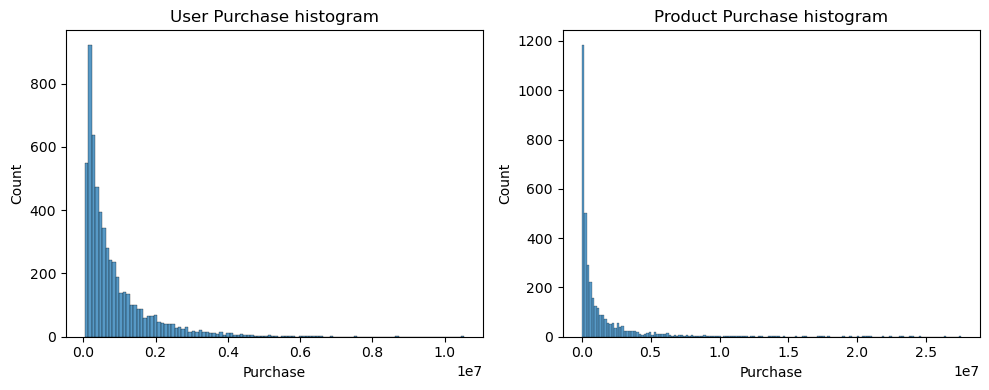

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

sns.histplot(data=user_data, x='Purchase', ax=axes[0])
axes[0].set_title('User Purchase histogram')

sns.histplot(data=product_data, x='Purchase', ax=axes[1])
axes[1].set_title('Product Purchase histogram')

plt.tight_layout()
plt.show()

用户的购买金额，产品的销售额，都大致呈指数分布。

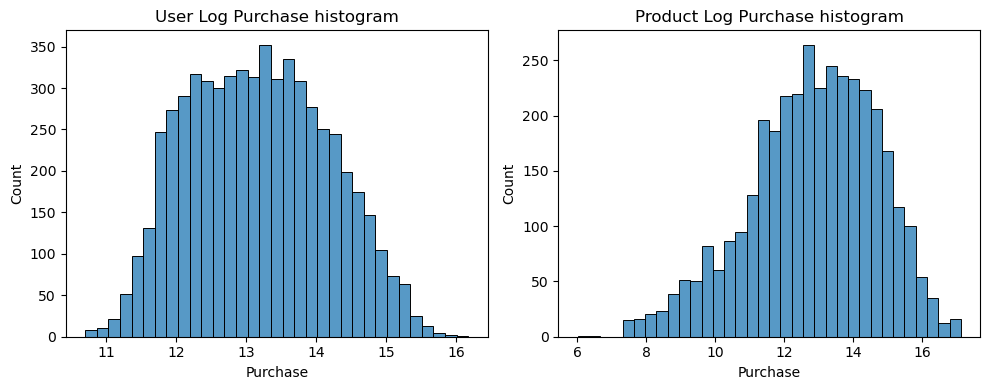

In [27]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

sns.histplot(x=np.log(user_data['Purchase']), ax=axes[0])
axes[0].set_title('User Log Purchase histogram')

sns.histplot(x=np.log(product_data['Purchase']), ax=axes[1])
axes[1].set_title('Product Log Purchase histogram')

plt.tight_layout()
plt.show()

将`user_data`和`product_data`中的Purchase数据进行对数变换后，更接近正态分布。

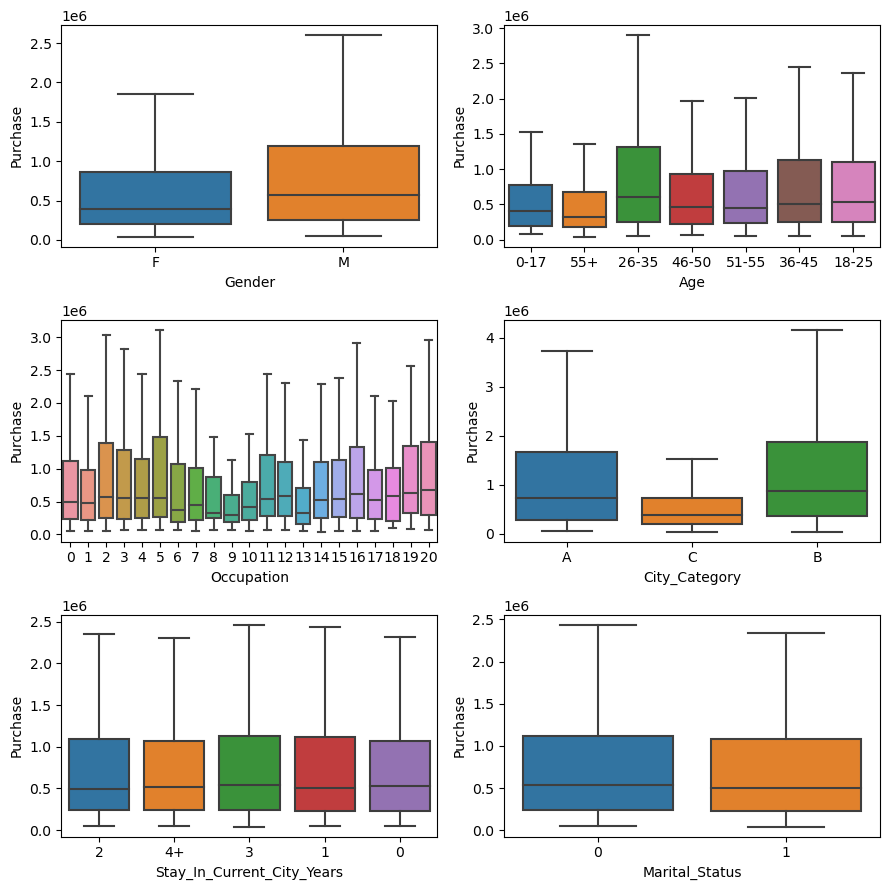

In [28]:
# 对user_data中的Purchase进行描述
fig, axes = plt.subplots(3, 2, figsize=(9, 9))
axes = axes.flatten()
for i, col in enumerate(user_data.drop(columns=['User_ID','Purchase'], axis=1).columns):
    sns.boxplot(data=user_data, y='Purchase', x=col, showfliers=False, ax=axes[i]) # showfliers=False, 不显示outliers
    
plt.tight_layout()
plt.show()

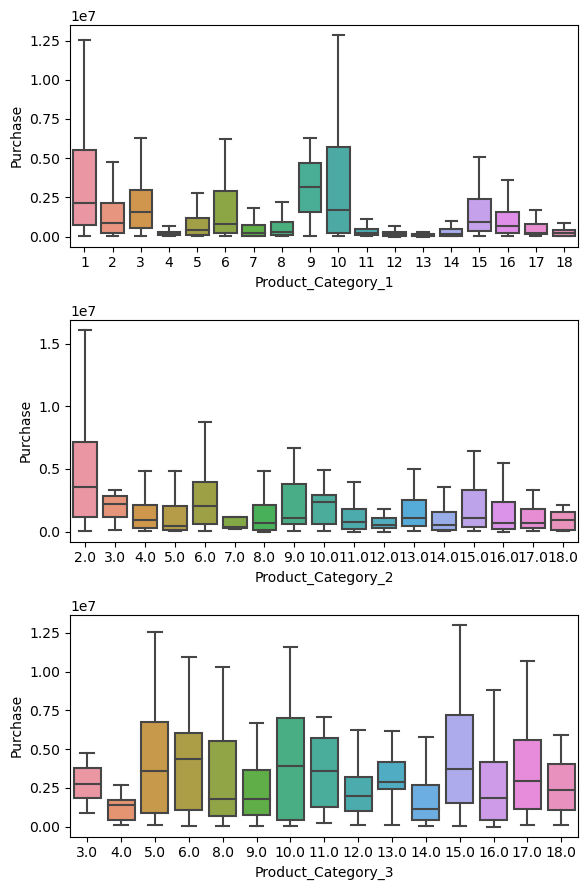

In [29]:
# 对product_data中的Purchase进行描述
fig, axes = plt.subplots(3, 1, figsize=(6, 9))
axes = axes.flatten()
for i, col in enumerate(product_data.drop(columns=['Product_ID','Purchase'], axis=1).columns):
    sns.boxplot(data=product_data, y='Purchase', x=col, showfliers=False, ax=axes[i]) # showfliers=False, 不显示outliers
    
plt.tight_layout()
plt.show()

### 对感兴趣的数据进一步探索：

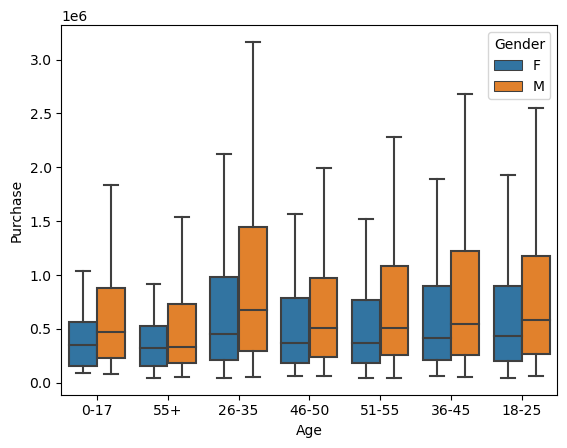

In [30]:
sns.boxplot(data=user_data, x='Age', y='Purchase', hue='Gender', showfliers=False)
plt.show()

##### 无论是哪个年龄段，女性的总消费额都比男性多。

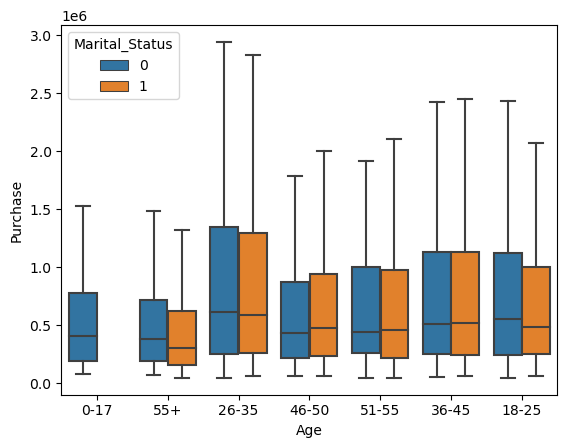

In [31]:
sns.boxplot(data=user_data, x='Age', y='Purchase', hue='Marital_Status', showfliers=False)
plt.show()

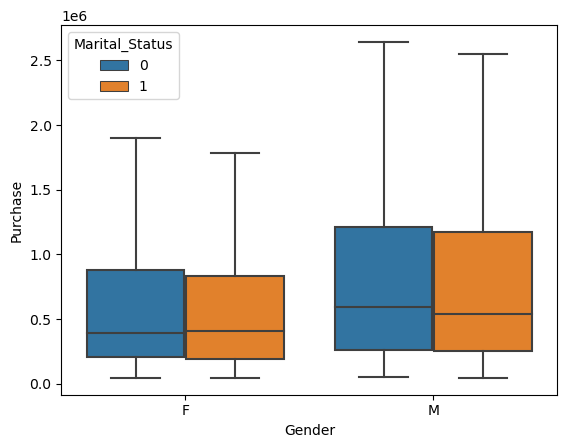

In [32]:
sns.boxplot(data=user_data, x='Gender', y='Purchase', hue='Marital_Status', showfliers=False)
plt.show()

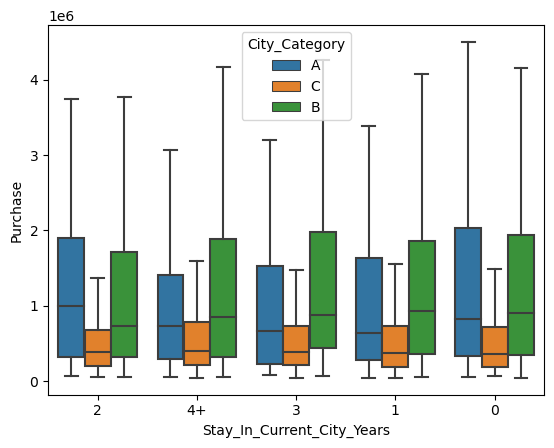

In [33]:
sns.boxplot(data=user_data, x='Stay_In_Current_City_Years', y='Purchase', hue='City_Category', showfliers=False)
plt.show()

C城居民的总消费额最小。

### 在原始数据集上对感兴趣的标签深入分析

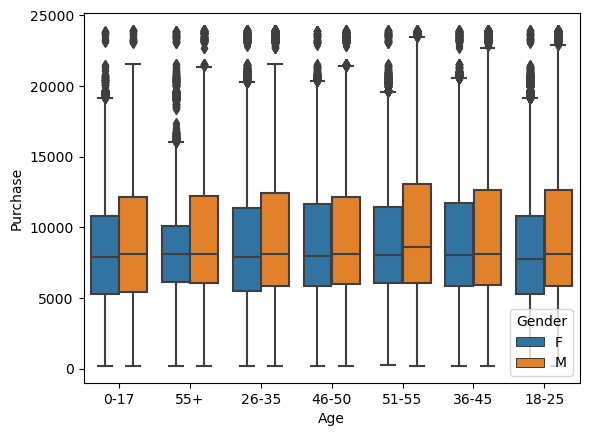

In [34]:
sns.boxplot(data=df0, x='Age', y='Purchase', hue='Gender')
plt.show()

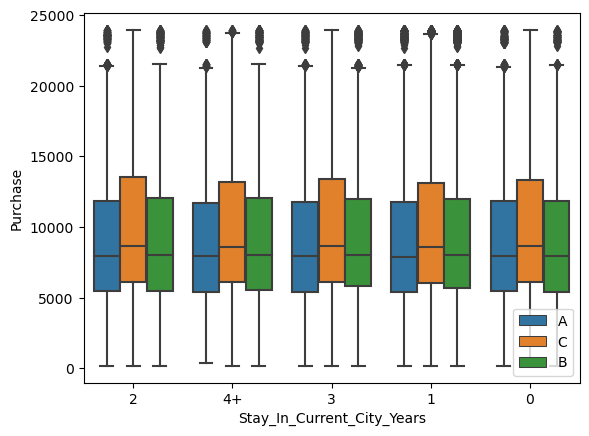

In [35]:
sns.boxplot(data=df0, x='Stay_In_Current_City_Years', y='Purchase', hue='City_Category') #, showfliers=False)
plt.legend(loc='best')
plt.show()

##### 虽然C城居民的总消费额最小，但是从单个产品消费的尺度来看，C城居民的消费水平却是最高的。

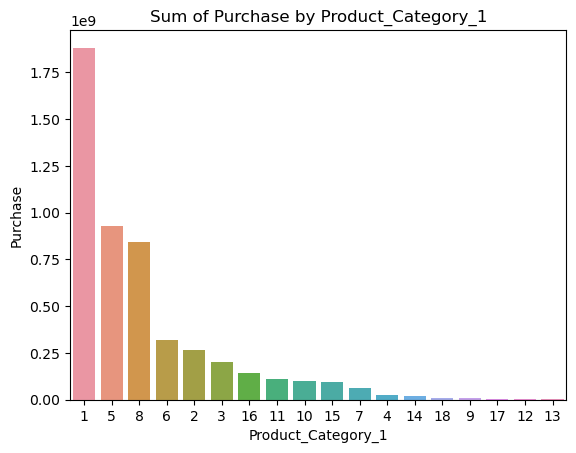

In [36]:
# 考察各种类别产品的销售额总数
sns.barplot(
            y=product_data.groupby(by=['Product_Category_1'])['Purchase'].sum().sort_values(ascending=False), 
            x=product_data.groupby(by=['Product_Category_1'])['Purchase'].sum().sort_values(ascending=False).index,
            order=product_data.groupby(by=['Product_Category_1'])['Purchase'].sum().sort_values(ascending=False).index)

plt.title('Sum of Purchase by Product_Category_1')
plt.show()

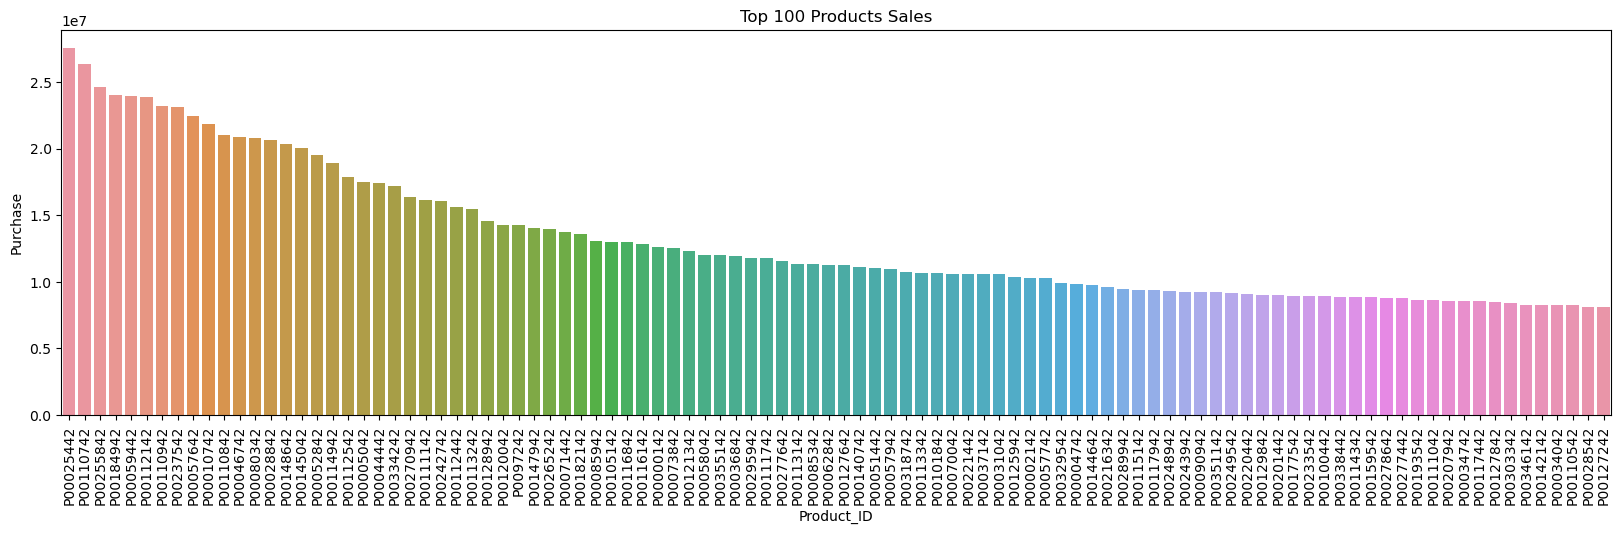

In [37]:
# 考察销售额最多的商品
plt.figure(figsize=(20,5))
sns.barplot(x=df0.groupby(by=['Product_ID'])['Purchase'].sum().sort_values(ascending=False).index[:100],
            y=df0.groupby(by=['Product_ID'])['Purchase'].sum().sort_values(ascending=False)[:100],
        )
plt.xticks(rotation=90)
plt.title('Top 100 Products Sales')
plt.show()

# 线性回归

`Product_Category_2`和`Product_Category_3`变量存在大量空值，用0填充这些空值，将空值视作一个单独的类别标签。

In [38]:
### Product_Category_2和Product_Category_3中的空值，用0填充，并转换成int。
df1 = df0.copy()
# 空值替换0
df1.loc[df1['Product_Category_2'].isna(), 'Product_Category_2'] = 0
df1.loc[df1['Product_Category_3'].isna(), 'Product_Category_3'] = 0

# 转换成int
df1['Product_Category_2'] = df1['Product_Category_2'].astype(int)
df1['Product_Category_3'] = df1['Product_Category_3'].astype(int)

df1.head()

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                   0                   0      8370  
1                   6                  14     15200  
2                   0                   0      1422  
3                  14                   0      1057  
4                   0                   0      7969

In [39]:
%%time

ols_formula = 'Purchase ~ C(Gender) + C(Age) + C(Occupation) + C(City_Category) + C(Stay_In_Current_City_Years) + C(Marital_Status) \
+ C(Product_Category_1) + C(Product_Category_2) + C(Product_Category_3)' 

#因变量为Purchase, 所有自变量均为标签类型，线性回归效果可能不太好

ols_model = ols(formula=ols_formula, data=df1).fit()

CPU times: total: 6.17 s
Wall time: 10.3 s


In [40]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Purchase   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                 1.147e+04
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:32:33   Log-Likelihood:            -5.0654e+06
No. Observations:              537577   AIC:                         1.013e+07
Df Residuals:                  537493   BIC:                         1.013e+07
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            1.323e+04     45.689    289.499      0.000    1.31e+04    1.33e+04
C(Gender)[T.M]                        -56.3370      9.971     -5.650      0.000     -75.880     -36.794
C(Age)[T.18-25]                      -175.6781     41.119     -4.272      0.000    -256.270     -95.087
C(Age)[T.26-35]                       -95.2772     40.999     -2.324      0.020    -175.634     -14.920
C(Age)[T.36-45]                        25.0643     41.584      0.603      0.547     -56.440     106.568
C(Age)[T.46-50]                        36.8183     43.432      0.848      0.397     -48.307     121.944
C(Age)[T.51-55]                       272.0308     43.925      6.193      0.000     185.938     358.123
C(Age)[T.55+]                         145.7665     46.531      3.133      0.002      54.567     236.965
C(Occupation)[T.1]                    -45.9297     18.235     -2.519      0.012     -81.669     -10.190
C(Occupation)[T.2]                     49.4873     21.937      2.256      0.024       6.491      92.484
C(Occupation)[T.3]                    243.1283     25.568      9.509      0.000     193.016     293.240
C(Occupation)[T.4]                    152.3357     17.437      8.736      0.000     118.160     186.511
C(Occupation)[T.5]                     61.4086     29.744      2.065      0.039       3.111     119.706
C(Occupation)[T.6]                    207.2074     24.417      8.486      0.000     159.351     255.064
C(Occupation)[T.7]                    108.5463     17.121      6.340      0.000      74.990     142.103
C(Occupation)[T.8]                   -286.2763     77.795     -3.680      0.000    -438.751    -133.801
C(Occupation)[T.9]                    106.3170     40.582      2.620      0.009      26.777     185.857
C(Occupation)[T.10]                   -38.9333     44.056     -0.884      0.377    -125.281      47.415
C(Occupation)[T.11]                    95.6426     30.484      3.137      0.002      35.895     155.390
C(Occupation)[T.12]                   284.9073     20.745     13.734      0.000     244.248     325.567
C(Occupation)[T.13]                    80.1721     39.244      2.043      0.041       3.255     157.089
C(Occupation)[T.14]                   188.8967     21.665      8.719      0.000     146.434     231.359
C(Occupation)[T.15]                   370.0482     29.887     12.381      0.000     311.470     428.627
C(Occupation)[T.16]                   108.4985     22.445      4.834      0.000      64.506     152.491
C(Occupation)[T.17]                   190.9038     19.191      9.948      0.000     153.291     228.517
C(Occupation)[T.18]                   -12.9438     38.965     -0.332      0.740     -89.314      63.427
C(Occupation)[T.19]                  -310.1054     34.933     -8.87

`R-squared`为0.639，F统计量显著，模型整体对因变量具有一定可解释性。

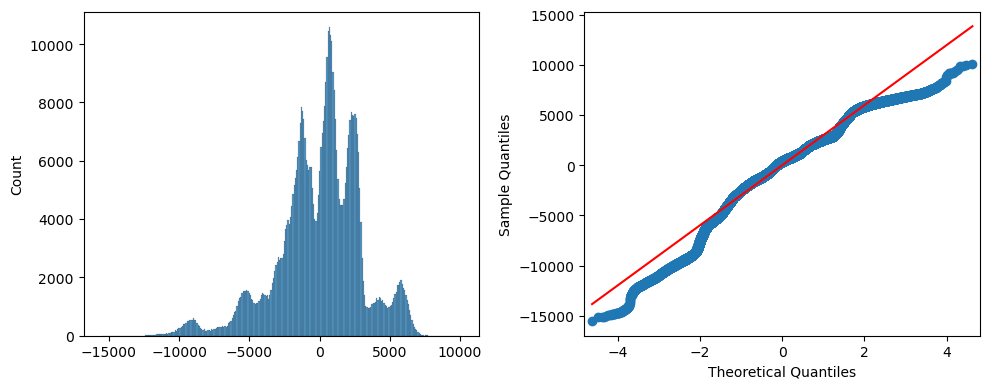

In [41]:
#绘制残差直方图和QQ图
ols_resid = ols_model.resid

fig, axes = plt.subplots(1, 2, figsize = (10,4))
sns.histplot(ols_resid, ax=axes[0])
sm.qqplot(ols_resid, line='s', ax=axes[1])

plt.tight_layout()
plt.show()

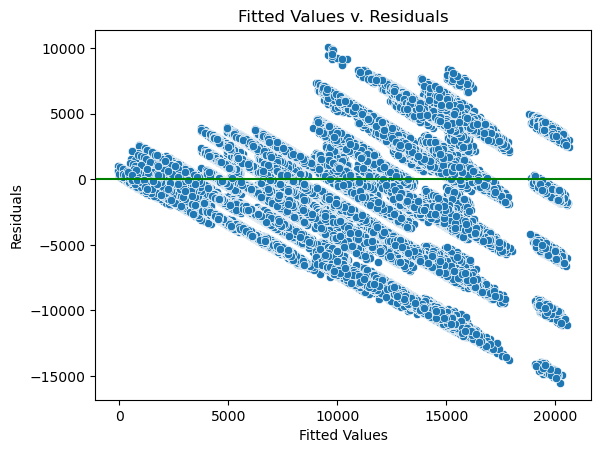

In [42]:
# 绘制残差-拟合值散点图
fig = sns.scatterplot(x = ols_model.fittedvalues, y = ols_resid)

fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Fitted Values v. Residuals")

fig.axhline(0, color='g')

plt.show()

残差不太满足正态分布，不满足独立同方差假设。

In [43]:
# 方差分析 ANOVA
sm.stats.anova_lm(ols_model)

df        sum_sq       mean_sq  \
C(Gender)                           1.0  4.815327e+10  4.815327e+10   
C(Age)                              6.0  6.087946e+09  1.014658e+09   
C(Occupation)                      20.0  3.607820e+10  1.803910e+09   
C(City_Category)                    2.0  6.153149e+10  3.076574e+10   
C(Stay_In_Current_City_Years)       4.0  4.820994e+08  1.205248e+08   
C(Marital_Status)                   1.0  4.921770e+08  4.921770e+08   
C(Product_Category_1)              17.0  8.265377e+12  4.861987e+11   
C(Product_Category_2)              17.0  3.836114e+10  2.256538e+09   
C(Product_Category_3)              15.0  6.833276e+10  4.555518e+09   
Residual                       537493.0  4.812677e+12  8.953934e+06   

                                          F         PR(>F)  
C(Gender)                       5377.889842   0.000000e+00  
C(Age)                           113.319763  1.637365e-143  
C(Occupation)                    201.465642   0.000000e+00  
C(City_Category)                3436.002760   0.000000e+00  
C(Stay_In_Current_City_Years)     13.460547   5.685828e-11  
C(Marital_Status)                 54.967683   1.227065e-13  
C(Product_Category_1)          54300.002950   0.000000e+00  
C(Product_Category_2)            252.016321   0.000000e+00  
C(Product_Category_3)            508.772735   0.000000e+00  
Residual                                NaN            NaN

ANOVA结果显示所有类别变量对因变量均有显著影响。

##### Tukey’s HSD post hoc test（考察类别变量中各标签之间对因变量的贡献是否显著不同）

In [44]:
# 性别类别
pairwise_tukeyhsd(endog = df0.Purchase, groups = df0.Gender).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

女性和男性两个类别的消费量显著不同。

In [45]:
# 所属城市类别
pairwise_tukeyhsd(endog = df0.Purchase, groups = df0.City_Category).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

三个城市之间相比，居民的消费显著不同。

In [46]:
# 年龄类别
pairwise_tukeyhsd(endog = df0.Purchase, groups = df0.Age).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

除18-25和46-50、26-35和46-50、36-45和55+三对类别外，其他类别之间均有显著区别。

In [47]:
# 产品类别1
pairwise_tukeyhsd(endog = df0.Purchase, groups = df0.Product_Category_1).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

除3和17、6和9、15和16三对产品类别1之外，其他产品类别1之间均有显著区别。

# 机器学习

#### 机器学习流程：
![jupyter](./机器学习流程.png)

#### 数据预处理：
对于决策树回归、随机森林回归，必须将类别变量转换为数值标签。

In [48]:
for col in df1.iloc[:,2:11].columns:
    print(str(col)+':', df1[col].unique())

Gender: ['F' 'M']
Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category: ['A' 'C' 'B']
Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
Marital_Status: [0 1]
Product_Category_1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9]
Product_Category_2: [ 0  6 14  2  8 15 16 11  5  3  4 12  9 10 17 13  7 18]
Product_Category_3: [ 0 14 17  5  4 16 15  8  9 13  6 12  3 18 11 10]


- Gender, City_Category, Marital_Status变量应当使用 One-Hot 编码
- Age, Stay_In_Current_City_Years变量存在内在大小顺序，应当用 Label encoding 方法
- Occupation, Product_Category_1, Product_Category_2, Product_Category_3 类别较多且无内在大小顺序，尝试使用`TargetEncoder`

In [49]:
# 转换Gender标签
df1['Gender'] = np.where(df1['Gender']=='M', 1, 0)
df1['Gender'].value_counts()

Gender
1    405380
0    132197
Name: count, dtype: int64

In [50]:
# 将Age标签转换成有序型离散变量，体现年龄大小关系
age_mapper = {'0-17':1,
              '18-25':2,
              '26-35':3,
              '36-45':4,
              '46-50':5,
              '51-55':6,
              '55+':7}

df1['Age'] = df0['Age'].map(age_mapper)
df1['Age'].value_counts()

Age
3    214690
4    107499
2     97634
5     44526
6     37618
7     20903
1     14707
Name: count, dtype: int64

In [51]:
# Stay_In_Current_City_Years 标签转换
years_dict = {'0':0,
              '1':1,
              '2':2,
              '3':3,
              '4+':4,
}

df1['Stay_In_Current_City_Years'] = df0['Stay_In_Current_City_Years'].map(years_dict)
df1['Stay_In_Current_City_Years'].value_counts()

Stay_In_Current_City_Years
1    189192
2     99459
3     93312
4     82889
0     72725
Name: count, dtype: int64

In [52]:
# City_Category 标签转换
df1 = pd.get_dummies(df1, columns=['City_Category'], drop_first=False) #由于是决策树模型，drop_first无需为True
df1.head() #确认是否成功变换

User_ID Product_ID  Gender  Age  Occupation  Stay_In_Current_City_Years  \
0  1000001  P00069042       0    1          10                           2   
1  1000001  P00248942       0    1          10                           2   
2  1000001  P00087842       0    1          10                           2   
3  1000001  P00085442       0    1          10                           2   
4  1000002  P00285442       1    7          16                           4   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  \
0               0                   3                   0                   0   
1               0                   1                   6                  14   
2               0                  12                   0                   0   
3               0                  12                  14                   0   
4               0                   8                   0                   0   

   Purchase  City_Category_A  City_Category_B  City_Category_C  
0      8370             True            False            False  
1     15200             True            False            False  
2      1422             True            False            False  
3      1057             True            False            False  
4      7969            False            False             True

In [53]:
# 定义X和y进行Target Encoding
target_X = df1[['Occupation', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
target_y = df1['Purchase']

# target encoder要求y必须为'binary'或'continuous'，因此将Purchase转化为float类型，除以100
target_y = target_y / 100

# 对Occupation, Product_Category_1, Product_Category_2, Product_Category_3 进行转换
X_trans = TargetEncoder(smooth="auto").fit_transform(target_X, target_y)
pd.DataFrame(X_trans)

0           1           2           3
0       90.654555  101.021647   76.946410   83.164392
1       90.654555  136.074867  114.890553  100.597047
2       90.543054   13.517109   76.878003   83.038676
3       90.401855   13.541282   70.971606   83.084420
4       94.451818   74.937619   76.997909   83.084420
...           ...         ...         ...         ...
537572  94.695987  136.071020  136.261180   83.038676
537573  94.491654  136.076778  103.683598  119.666131
537574  94.770264   74.960188  103.564443   83.071746
537575  94.770264   62.377106   77.010260   83.071746
537576  94.446477   62.404324  102.752098   83.164392

[537577 rows x 4 columns]

In [54]:
# 将转化后的Occupation, Product_Category_1, Product_Category_2, Product_Category_3放到数据表中
df1[['Occupation', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']] = X_trans
df1.head()

User_ID Product_ID  Gender  Age  Occupation  Stay_In_Current_City_Years  \
0  1000001  P00069042       0    1   90.654555                           2   
1  1000001  P00248942       0    1   90.654555                           2   
2  1000001  P00087842       0    1   90.543054                           2   
3  1000001  P00085442       0    1   90.401855                           2   
4  1000002  P00285442       1    7   94.451818                           4   

   Marital_Status  Product_Category_1  Product_Category_2  Product_Category_3  \
0               0          101.021647           76.946410           83.164392   
1               0          136.074867          114.890553          100.597047   
2               0           13.517109           76.878003           83.038676   
3               0           13.541282           70.971606           83.084420   
4               0           74.937619           76.997909           83.084420   

   Purchase  City_Category_A  City_Category_B  City_Category_C  
0      8370             True            False            False  
1     15200             True            False            False  
2      1422             True            False            False  
3      1057             True            False            False  
4      7969            False            False             True

In [55]:
# 划分X，y, 训练集，验证集，测试集
X = df1.drop(columns=['User_ID', 'Product_ID', 'Purchase'])
y = df1['Purchase']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [57]:
%%time
#决策树回归
dtr = DecisionTreeRegressor(random_state=42)

dtr.fit(X_tr, y_tr)

CPU times: total: 281 ms
Wall time: 1.7 s


DecisionTreeRegressor(random_state=42)

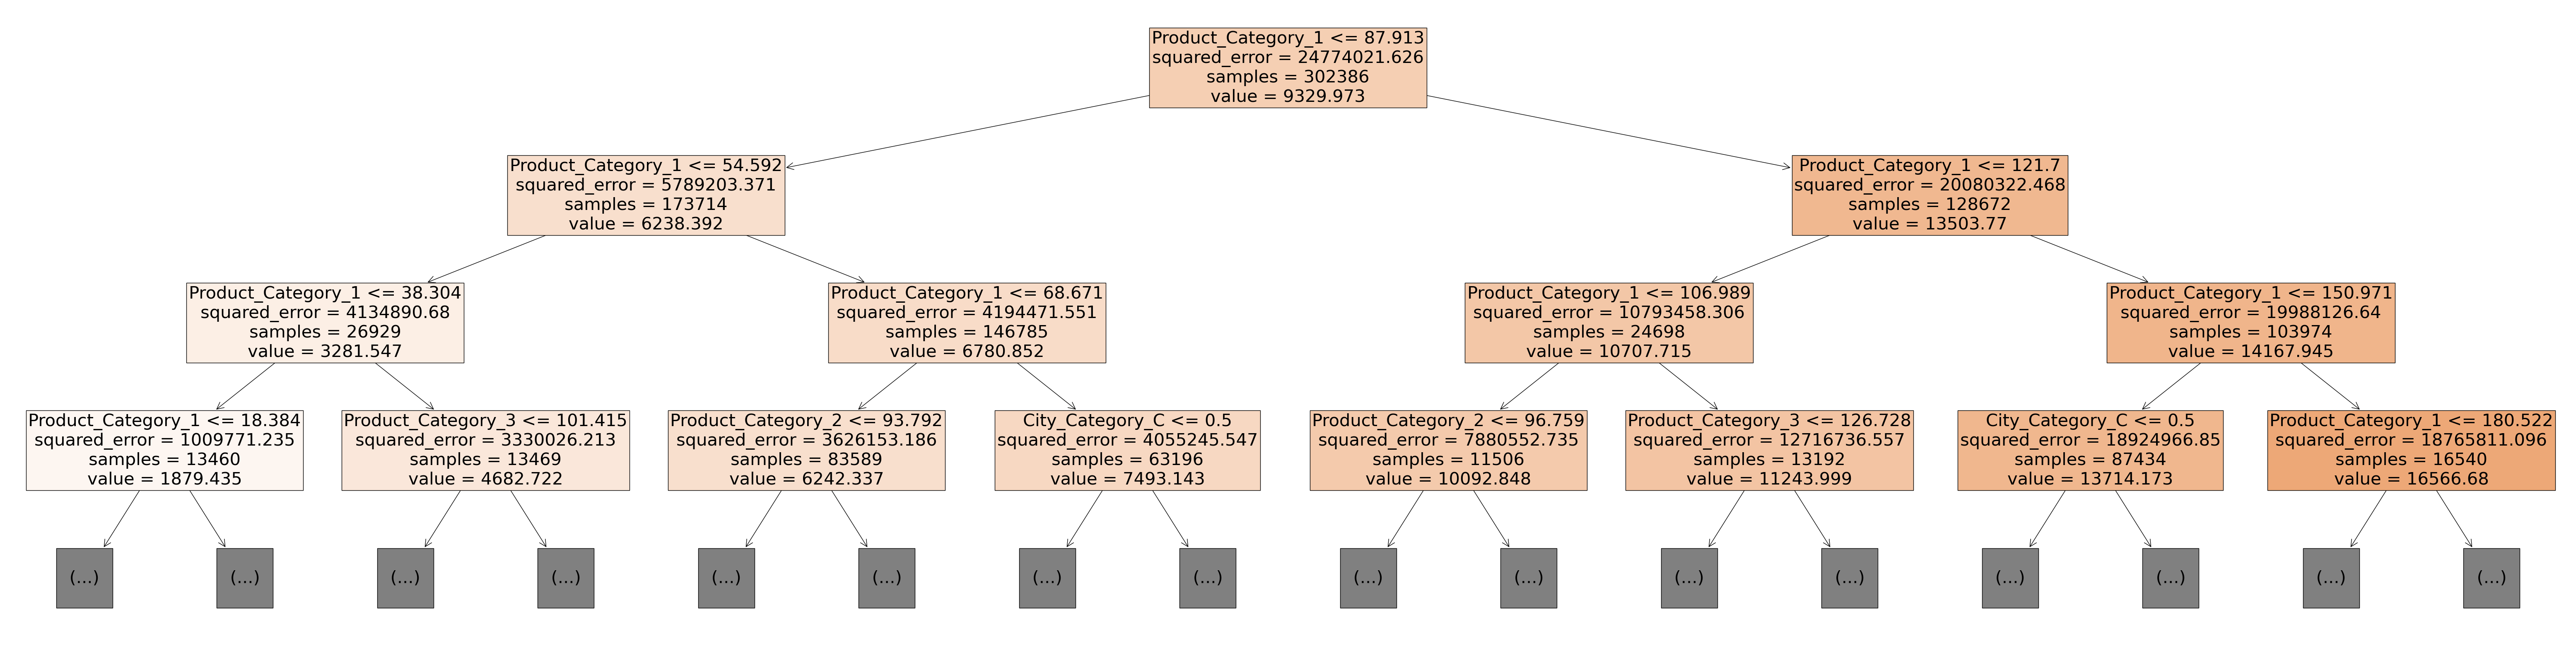

In [58]:
# 绘制决策树
plt.figure(figsize=(80,20))
plot_tree(dtr, max_depth=3, fontsize=30, feature_names=X.columns.tolist(), 
          filled=True)
plt.show()

In [59]:
%%time
#随机森林回归
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_tr, y_tr)

CPU times: total: 14.5 s
Wall time: 1min 53s


RandomForestRegressor(random_state=42)

In [60]:
%%time
#XGB回归
xgbr = XGBRegressor(random_state=42)

xgbr.fit(X_tr, y_tr)

CPU times: total: 4.59 s
Wall time: 2.29 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [61]:
# 存储三类模型在验证集上的输出结果
dtr_pred = dtr.predict(X_val)
rfr_pred = rfr.predict(X_val)
xgbr_pred = xgbr.predict(X_val)

In [62]:
# 定义函数，进行模型评估
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A regression model
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of mse, mae, r2 scores for your model
    '''

    preds = model.predict(X_test_data)

    mse = mean_squared_error(y_test_data, preds)
    mae = mean_absolute_error(y_test_data, preds)
    r2 = r2_score(y_test_data, preds)
    

    table = pd.DataFrame({'model': [model_name],
                          'MSE': [mse], 
                          'MAE': [mae],
                          'R2': [r2],
                         })
  
    return table

In [63]:
results_table = pd.concat([get_scores('Decision Tree Regressor', dtr, X_val, y_val),
                           get_scores('Random Forest Regressor', rfr, X_val, y_val),
                           get_scores('XGBoost Regressor', xgbr, X_val, y_val)],
                           
                           ignore_index=True)

results_table

model           MSE          MAE        R2
0  Decision Tree Regressor  1.469480e+07  2692.372598  0.408126
1  Random Forest Regressor  9.898501e+06  2316.611743  0.601310
2        XGBoost Regressor  8.482433e+06  2182.630368  0.658347

#### 根据评估结果发现，XGBoost模型在验证集的表现最好。

#### 下面用XGBoost模型做网格搜索，用最优模型在训练集和验证集进行训练，并在测试集上进行评估

In [64]:
# 交叉验证所需参数
cv_params = {'max_depth': [2, 4, 6], 
             'max_leaves': [3,5],
             'n_estimators': [50, 100, 200],
             }  

#定义评估分数
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#进行网格搜索
xgb_cv = GridSearchCV(XGBRegressor(random_state=42), 
                      cv_params, 
                      scoring=scoring, 
                      cv=4, 
                      refit='r2',
                      n_jobs=-1, # 用所有的处理器平行处理
                      verbose=2
                      )

In [65]:
%%time
xgb_cv.fit(X_train, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
CPU times: total: 7.53 s
Wall time: 25.5 s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6], 'max_leaves': [3, 5],
                         'n_estimators': [50, 100, 200]},
             refit='r2',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=2)

In [66]:
# 保存xgb_cv为pickle文件
with open('./xgb_cv.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [67]:
# 打开xgb_cv.picke
with open('./xgb_cv.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [68]:
# xgb的最优参数
xgb_cv.best_params_

{'max_depth': 4, 'max_leaves': 5, 'n_estimators': 200}

In [69]:
# 在测试集上评估最优模型
get_scores('XGB CV', xgb_cv.best_estimator_, X_test, y_test)

model           MSE          MAE        R2
0  XGB CV  8.889073e+06  2257.856848  0.642717

# 输出预测因变量的特征重要性

In [70]:
# 输出在最优模型上的各个特征的基尼重要性
feature_importances = pd.DataFrame(xgb_cv.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
feature_importances = feature_importances.sort_values(by='gini_importance', ascending=False)
feature_importances

gini_importance
Product_Category_1                 0.899715
City_Category_C                    0.046328
City_Category_A                    0.015302
Product_Category_3                 0.009838
Age                                0.006867
Product_Category_2                 0.005988
Gender                             0.004501
Occupation                         0.004361
City_Category_B                    0.003775
Stay_In_Current_City_Years         0.002546
Marital_Status                     0.000780

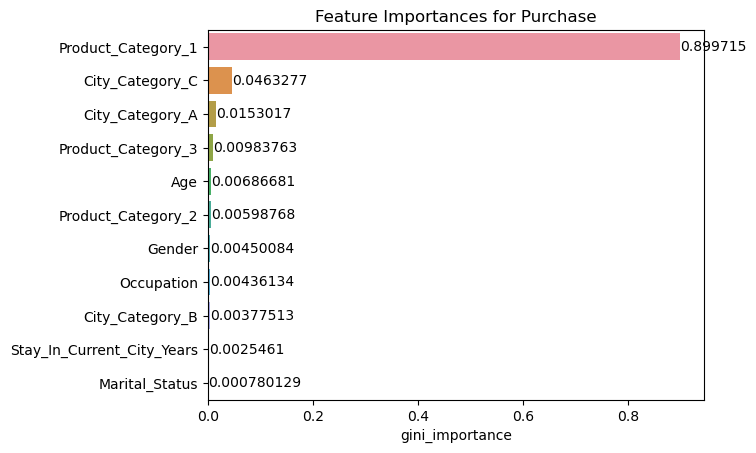

In [71]:
ax = sns.barplot(x=feature_importances.gini_importance, y=feature_importances.index)
ax.bar_label(ax.containers[0], fontsize=10);
ax.set_title('Feature Importances for Purchase')
plt.show()

# 结论

- 对于预测顾客对产品的消费金额来说，产品所属的类别，即产品本身的特征是最重要的。

- 其次，顾客所在的城市也是较为重要的因素。C城市居民的消费习惯与其他两城的居民显著不同。